# Random Walk with Function Approximation

<img src="randomwalk_diagram.png" alt="environment">

In [1]:
import numpy as np
from agent import Agent
from environment import Environment
from rlglue import RLGlue
import time
import tensorflow as tf
from qfunction import QFunction
from policy import Policy
from vfunction import VFunction
import matplotlib.pyplot as plt

In [2]:
class RandomWalk(Environment):
    def env_init(self, env_info={}):
        reward = None
        observation = None
        is_terminal = None
        self.reward_obs_term = (reward, observation, is_terminal)

        self.rand_generator = np.random.RandomState(env_info.get("seed"))
                
        self.start_state = 250.
        self.left_terminal_state = 0. 
        self.right_terminal_state = 500.
        
    def env_start(self):
        reward = 0.
        
        self.current_state = self.start_state
        state = self.start_state
        
        is_terminal = False
        
        self.reward_obs_term = (reward, state, is_terminal)
        return self.reward_obs_term[1]
    
    def env_step(self, action):
        if action == 0:
            self.current_state = max(self.left_terminal_state, self.current_state - self.rand_generator.uniform(low=1, high=101))

        elif action == 1:
            self.current_state = min(self.right_terminal_state, self.current_state + self.rand_generator.uniform(low=1, high=101))

        else:
            raise ValueError("Wrong action value")
        
        reward = 0.
        is_terminal = False

        if self.current_state == self.left_terminal_state:
            reward = -1.
            is_terminal = True
        elif self.current_state == self.right_terminal_state:
            reward = 1.
            is_terminal = True
        
        self.reward_obs_term = (reward, self.current_state, is_terminal)

        return self.reward_obs_term

    def env_cleanup(self):
        self.current_state = None

In [3]:
class SARSA(Agent):
    def agent_init(self, agent_info={}):
        self.rand_generator = np.random.RandomState(agent_info.get("seed"))
        
        self.discount = agent_info.get("discount")
        self.epsilon = agent_info.get("epsilon")
        self.decay_factor = agent_info.get("decay_factor")
        
        self.q = QFunction() 
        self.policy = Policy(self.q, self.epsilon)
        
    def agent_start(self, state):        
        action = self.agent_action(state)
        self.last_state = state
        self.last_action = action
        
        return action

    def agent_step(self, reward, state):         
        action = self.agent_action(state)
        
        target = reward + self.discount*self.q.predict(np.array([[state, action]])) 
        self.q.fit(np.array([[self.last_state, self.last_action]]), target)
        
        self.agent_improvement()
        
        self.last_state = state
        self.last_action = action

        return action

    def agent_end(self, reward):                    
        target = np.array([[reward]])
        
        self.q.fit(np.array([[self.last_state, self.last_action]]), target)
        
        self.agent_improvement()

        
    def agent_cleanup(self):
        self.last_state = None
        self.last_action = None
                       
    def agent_action(self, state):
        p = self.policy.predict(np.array([[state]]))
        return self.rand_generator.choice(range(p.shape[1]), p=p.flatten())
    
    def agent_improvement(self):
        self.epsilon = self.decay_factor*self.epsilon
        self.policy = Policy(self.q, self.epsilon)

In [4]:
class PolicyIteration(RLGlue):
    def rl_run(self, env_info, agent_info, num_episodes, max_steps_this_episode, verbose=True):
        self.rl_init(agent_info, env_info)
        for episode in range(num_episodes):
            start_time = time.time()
            self.rl_episode(max_steps_this_episode)
            now = time.time()
            duration = now - start_time
            if verbose:
                print('Episode: {}/{} - Steps: {} - Epsilon: {}'.format(episode+1, num_episodes, self.num_steps, self.agent.epsilon))
                print('----- {}s -----'.format(np.round(1000*duration)/1000))

        self.rl_cleanup()
        return self.agent.policy

-----

In [5]:
env_info = {}

random_walk = RandomWalk()

In [6]:
agent_info = {"discount": 1.,
              "epsilon": 0.9,
              "decay_factor": 0.9999}

sarsa = SARSA()

In [7]:
num_episodes = 1000
max_steps_this_episode = float('inf')

policy_iteration = PolicyIteration(env=random_walk, agent=sarsa)
optimal_policy = policy_iteration.rl_run(env_info=env_info,
                                         agent_info=agent_info,
                                         num_episodes=num_episodes,
                                         max_steps_this_episode=max_steps_this_episode)

Episode: 1/1000 - Steps: 47 - Epsilon: 0.8957797144225397
----- 0.319s -----
Episode: 2/1000 - Steps: 23 - Epsilon: 0.8937216858164124
----- 0.152s -----
Episode: 3/1000 - Steps: 3 - Epsilon: 0.8934535961214244
----- 0.02s -----
Episode: 4/1000 - Steps: 11 - Epsilon: 0.8924712884177785
----- 0.076s -----
Episode: 5/1000 - Steps: 33 - Epsilon: 0.8895308405487291
----- 0.22s -----
Episode: 6/1000 - Steps: 14 - Epsilon: 0.8882863065213256
----- 0.094s -----
Episode: 7/1000 - Steps: 17 - Epsilon: 0.8867774272657929
----- 0.112s -----
Episode: 8/1000 - Steps: 11 - Epsilon: 0.8858024596770965
----- 0.075s -----
Episode: 9/1000 - Steps: 31 - Epsilon: 0.8830605870546389
----- 0.207s -----
Episode: 10/1000 - Steps: 19 - Epsilon: 0.8813842811174953
----- 0.161s -----
Episode: 11/1000 - Steps: 12 - Epsilon: 0.880327201499919
----- 0.084s -----
Episode: 12/1000 - Steps: 22 - Epsilon: 0.8783925138573948
----- 0.145s -----
Episode: 13/1000 - Steps: 6 - Epsilon: 0.877865610090391
----- 0.04s -----
Ep

Episode: 107/1000 - Steps: 25 - Epsilon: 0.7341288642992517
----- 0.165s -----
Episode: 108/1000 - Steps: 23 - Epsilon: 0.7324422239578977
----- 0.152s -----
Episode: 109/1000 - Steps: 6 - Epsilon: 0.7320028684752088
----- 0.039s -----
Episode: 110/1000 - Steps: 12 - Epsilon: 0.7311249479939274
----- 0.08s -----
Episode: 111/1000 - Steps: 61 - Epsilon: 0.7266784391226372
----- 0.401s -----
Episode: 112/1000 - Steps: 7 - Epsilon: 0.7261699167922924
----- 0.046s -----
Episode: 113/1000 - Steps: 12 - Epsilon: 0.7252989920045653
----- 0.078s -----
Episode: 114/1000 - Steps: 18 - Epsilon: 0.723994562934793
----- 0.119s -----
Episode: 115/1000 - Steps: 13 - Epsilon: 0.7230539345117264
----- 0.085s -----
Episode: 116/1000 - Steps: 16 - Epsilon: 0.7218979154764505
----- 0.104s -----
Episode: 117/1000 - Steps: 42 - Epsilon: 0.7188721514931881
----- 0.276s -----
Episode: 118/1000 - Steps: 18 - Epsilon: 0.7175792809085125
----- 0.117s -----
Episode: 119/1000 - Steps: 27 - Epsilon: 0.7156443334556

Episode: 214/1000 - Steps: 21 - Epsilon: 0.6184250486758458
----- 0.139s -----
Episode: 215/1000 - Steps: 6 - Epsilon: 0.6180540863980301
----- 0.04s -----
Episode: 216/1000 - Steps: 18 - Epsilon: 0.6169425341611231
----- 0.117s -----
Episode: 217/1000 - Steps: 4 - Epsilon: 0.616695794161543
----- 0.026s -----
Episode: 218/1000 - Steps: 6 - Epsilon: 0.6163258691770823
----- 0.04s -----
Episode: 219/1000 - Steps: 35 - Epsilon: 0.6141723917432563
----- 0.231s -----
Episode: 220/1000 - Steps: 6 - Epsilon: 0.6138039804217867
----- 0.039s -----
Episode: 221/1000 - Steps: 9 - Epsilon: 0.6132517777572882
----- 0.059s -----
Episode: 222/1000 - Steps: 12 - Epsilon: 0.6125162802352679
----- 0.079s -----
Episode: 223/1000 - Steps: 5 - Epsilon: 0.6122100833406535
----- 0.034s -----
Episode: 224/1000 - Steps: 4 - Epsilon: 0.6119652360374735
----- 0.027s -----
Episode: 225/1000 - Steps: 8 - Epsilon: 0.6114758351646439
----- 0.053s -----
Episode: 226/1000 - Steps: 26 - Epsilon: 0.6098879837007565
---

Episode: 319/1000 - Steps: 32 - Epsilon: 0.5397300982866032
----- 0.212s -----
Episode: 320/1000 - Steps: 6 - Epsilon: 0.5394063411763523
----- 0.039s -----
Episode: 321/1000 - Steps: 5 - Epsilon: 0.5391366919410044
----- 0.032s -----
Episode: 322/1000 - Steps: 32 - Epsilon: 0.5374141259726052
----- 0.217s -----
Episode: 323/1000 - Steps: 5 - Epsilon: 0.5371454726456575
----- 0.034s -----
Episode: 324/1000 - Steps: 10 - Epsilon: 0.5366085688240284
----- 0.068s -----
Episode: 325/1000 - Steps: 36 - Epsilon: 0.5346801547820194
----- 0.238s -----
Episode: 326/1000 - Steps: 4 - Epsilon: 0.5344663147987772
----- 0.026s -----
Episode: 327/1000 - Steps: 14 - Epsilon: 0.533718548127913
----- 0.092s -----
Episode: 328/1000 - Steps: 9 - Epsilon: 0.5332383935284496
----- 0.059s -----
Episode: 329/1000 - Steps: 27 - Epsilon: 0.5318005199738975
----- 0.178s -----
Episode: 330/1000 - Steps: 17 - Epsilon: 0.5308971819771515
----- 0.112s -----
Episode: 331/1000 - Steps: 7 - Epsilon: 0.5305256654195961

Episode: 427/1000 - Steps: 8 - Epsilon: 0.47597384783591073
----- 0.054s -----
Episode: 428/1000 - Steps: 8 - Epsilon: 0.47559320200366817
----- 0.053s -----
Episode: 429/1000 - Steps: 5 - Epsilon: 0.47535545295723086
----- 0.033s -----
Episode: 430/1000 - Steps: 7 - Epsilon: 0.47502280394817015
----- 0.047s -----
Episode: 431/1000 - Steps: 7 - Epsilon: 0.4746903877235712
----- 0.046s -----
Episode: 432/1000 - Steps: 3 - Epsilon: 0.4745479948474911
----- 0.02s -----
Episode: 433/1000 - Steps: 16 - Epsilon: 0.47378928724766844
----- 0.11s -----
Episode: 434/1000 - Steps: 5 - Epsilon: 0.47355243997823565
----- 0.033s -----
Episode: 435/1000 - Steps: 7 - Epsilon: 0.4732210526996906
----- 0.047s -----
Episode: 436/1000 - Steps: 6 - Epsilon: 0.47293719104176496
----- 0.042s -----
Episode: 437/1000 - Steps: 4 - Epsilon: 0.47274804453968805
----- 0.027s -----
Episode: 438/1000 - Steps: 12 - Epsilon: 0.4721810587959687
----- 0.08s -----
Episode: 439/1000 - Steps: 6 - Epsilon: 0.471897820978407

Episode: 532/1000 - Steps: 11 - Epsilon: 0.42745864029245556
----- 0.074s -----
Episode: 533/1000 - Steps: 6 - Epsilon: 0.4272022292185276
----- 0.04s -----
Episode: 534/1000 - Steps: 12 - Epsilon: 0.42668986840297335
----- 0.079s -----
Episode: 535/1000 - Steps: 9 - Epsilon: 0.42630600109392675
----- 0.059s -----
Episode: 536/1000 - Steps: 19 - Epsilon: 0.42549674826218487
----- 0.127s -----
Episode: 537/1000 - Steps: 6 - Epsilon: 0.42524151402923055
----- 0.041s -----
Episode: 538/1000 - Steps: 11 - Epsilon: 0.4247739821764803
----- 0.073s -----
Episode: 539/1000 - Steps: 11 - Epsilon: 0.4243069643517027
----- 0.072s -----
Episode: 540/1000 - Steps: 5 - Epsilon: 0.4240948532959804
----- 0.034s -----
Episode: 541/1000 - Steps: 12 - Epsilon: 0.42358621928134865
----- 0.079s -----
Episode: 542/1000 - Steps: 8 - Epsilon: 0.4232474688863472
----- 0.053s -----
Episode: 543/1000 - Steps: 6 - Epsilon: 0.4229935838836714
----- 0.039s -----
Episode: 544/1000 - Steps: 9 - Epsilon: 0.42261304190

Episode: 639/1000 - Steps: 6 - Epsilon: 0.39113512774878817
----- 0.041s -----
Episode: 640/1000 - Steps: 9 - Epsilon: 0.39078324690960986
----- 0.059s -----
Episode: 641/1000 - Steps: 5 - Epsilon: 0.3905878943605721
----- 0.033s -----
Episode: 642/1000 - Steps: 7 - Epsilon: 0.3903145648443084
----- 0.046s -----
Episode: 643/1000 - Steps: 9 - Epsilon: 0.3899634222164104
----- 0.059s -----
Episode: 644/1000 - Steps: 18 - Epsilon: 0.38926208438236604
----- 0.119s -----
Episode: 645/1000 - Steps: 12 - Epsilon: 0.38879522670846456
----- 0.079s -----
Episode: 646/1000 - Steps: 10 - Epsilon: 0.38840660639296093
----- 0.066s -----
Episode: 647/1000 - Steps: 5 - Epsilon: 0.3882124419265412
----- 0.033s -----
Episode: 648/1000 - Steps: 15 - Epsilon: 0.38763053071013176
----- 0.101s -----
Episode: 649/1000 - Steps: 10 - Epsilon: 0.38724307456665297
----- 0.066s -----
Episode: 650/1000 - Steps: 8 - Epsilon: 0.3869333885133777
----- 0.053s -----
Episode: 651/1000 - Steps: 7 - Epsilon: 0.3866626163

Episode: 745/1000 - Steps: 4 - Epsilon: 0.3582921482795036
----- 0.027s -----
Episode: 746/1000 - Steps: 25 - Epsilon: 0.3573974919616309
----- 0.166s -----
Episode: 747/1000 - Steps: 10 - Epsilon: 0.3570402552556605
----- 0.067s -----
Episode: 748/1000 - Steps: 17 - Epsilon: 0.3564337721537707
----- 0.111s -----
Episode: 749/1000 - Steps: 6 - Epsilon: 0.35621996534841616
----- 0.039s -----
Episode: 750/1000 - Steps: 5 - Epsilon: 0.3560418909841765
----- 0.035s -----
Episode: 751/1000 - Steps: 9 - Epsilon: 0.35572158142746846
----- 0.062s -----
Episode: 752/1000 - Steps: 6 - Epsilon: 0.3555082018297353
----- 0.04s -----
Episode: 753/1000 - Steps: 5 - Epsilon: 0.35533048327608574
----- 0.033s -----
Episode: 754/1000 - Steps: 5 - Epsilon: 0.3551528535639429
----- 0.033s -----
Episode: 755/1000 - Steps: 12 - Epsilon: 0.3547269044624335
----- 0.078s -----
Episode: 756/1000 - Steps: 21 - Epsilon: 0.35398272241798723
----- 0.14s -----
Episode: 757/1000 - Steps: 7 - Epsilon: 0.353735008836278

Episode: 851/1000 - Steps: 6 - Epsilon: 0.3278788810044104
----- 0.041s -----
Episode: 852/1000 - Steps: 5 - Epsilon: 0.3277149743485177
----- 0.034s -----
Episode: 853/1000 - Steps: 4 - Epsilon: 0.3275839080203659
----- 0.027s -----
Episode: 854/1000 - Steps: 7 - Epsilon: 0.32735466806590807
----- 0.047s -----
Episode: 855/1000 - Steps: 16 - Epsilon: 0.3268312932393453
----- 0.108s -----
Episode: 856/1000 - Steps: 5 - Epsilon: 0.3266679102725868
----- 0.035s -----
Episode: 857/1000 - Steps: 5 - Epsilon: 0.32650460898097505
----- 0.034s -----
Episode: 858/1000 - Steps: 9 - Epsilon: 0.3262108723471292
----- 0.06s -----
Episode: 859/1000 - Steps: 6 - Epsilon: 0.32601519474882806
----- 0.04s -----
Episode: 860/1000 - Steps: 6 - Epsilon: 0.3258196345277382
----- 0.041s -----
Episode: 861/1000 - Steps: 4 - Epsilon: 0.32568932622180197
----- 0.027s -----
Episode: 862/1000 - Steps: 15 - Epsilon: 0.3252011340581177
----- 0.101s -----
Episode: 863/1000 - Steps: 5 - Epsilon: 0.32503856600795017


Episode: 958/1000 - Steps: 34 - Epsilon: 0.29995720805389164
----- 0.229s -----
Episode: 959/1000 - Steps: 17 - Epsilon: 0.2994476885381036
----- 0.113s -----
Episode: 960/1000 - Steps: 10 - Epsilon: 0.299148375565098
----- 0.066s -----
Episode: 961/1000 - Steps: 7 - Epsilon: 0.2989390345128922
----- 0.048s -----
Episode: 962/1000 - Steps: 19 - Epsilon: 0.2983715612435107
----- 0.128s -----
Episode: 963/1000 - Steps: 19 - Epsilon: 0.2978051652035114
----- 0.133s -----
Episode: 964/1000 - Steps: 12 - Epsilon: 0.2974479954911738
----- 0.081s -----
Episode: 965/1000 - Steps: 4 - Epsilon: 0.29732903413866735
----- 0.027s -----
Episode: 966/1000 - Steps: 22 - Epsilon: 0.29667559663596194
----- 0.15s -----
Episode: 967/1000 - Steps: 9 - Epsilon: 0.29640869537728737
----- 0.061s -----
Episode: 968/1000 - Steps: 5 - Epsilon: 0.2962605206675043
----- 0.033s -----
Episode: 969/1000 - Steps: 7 - Epsilon: 0.2960532005073784
----- 0.047s -----
Episode: 970/1000 - Steps: 6 - Epsilon: 0.2958756129891

In [8]:
S_test = []
for x in np.round(np.linspace(0., 501., 500), 3):
    S_test.append([x])
S_test = np.array(S_test)
S_test

array([[  0.   ],
       [  1.004],
       [  2.008],
       [  3.012],
       [  4.016],
       [  5.02 ],
       [  6.024],
       [  7.028],
       [  8.032],
       [  9.036],
       [ 10.04 ],
       [ 11.044],
       [ 12.048],
       [ 13.052],
       [ 14.056],
       [ 15.06 ],
       [ 16.064],
       [ 17.068],
       [ 18.072],
       [ 19.076],
       [ 20.08 ],
       [ 21.084],
       [ 22.088],
       [ 23.092],
       [ 24.096],
       [ 25.1  ],
       [ 26.104],
       [ 27.108],
       [ 28.112],
       [ 29.116],
       [ 30.12 ],
       [ 31.124],
       [ 32.128],
       [ 33.132],
       [ 34.136],
       [ 35.14 ],
       [ 36.144],
       [ 37.148],
       [ 38.152],
       [ 39.156],
       [ 40.16 ],
       [ 41.164],
       [ 42.168],
       [ 43.172],
       [ 44.176],
       [ 45.18 ],
       [ 46.184],
       [ 47.188],
       [ 48.192],
       [ 49.196],
       [ 50.2  ],
       [ 51.204],
       [ 52.208],
       [ 53.212],
       [ 54.216],
       [ 5

In [9]:
optimal_policy.predict(S_test)

array([[0.14486335, 0.85513665],
       [0.14486335, 0.85513665],
       [0.14486335, 0.85513665],
       [0.14486335, 0.85513665],
       [0.14486335, 0.85513665],
       [0.14486335, 0.85513665],
       [0.14486335, 0.85513665],
       [0.14486335, 0.85513665],
       [0.14486335, 0.85513665],
       [0.14486335, 0.85513665],
       [0.14486335, 0.85513665],
       [0.14486335, 0.85513665],
       [0.14486335, 0.85513665],
       [0.14486335, 0.85513665],
       [0.14486335, 0.85513665],
       [0.14486335, 0.85513665],
       [0.14486335, 0.85513665],
       [0.14486335, 0.85513665],
       [0.14486335, 0.85513665],
       [0.14486335, 0.85513665],
       [0.14486335, 0.85513665],
       [0.14486335, 0.85513665],
       [0.14486335, 0.85513665],
       [0.14486335, 0.85513665],
       [0.14486335, 0.85513665],
       [0.14486335, 0.85513665],
       [0.14486335, 0.85513665],
       [0.14486335, 0.85513665],
       [0.14486335, 0.85513665],
       [0.14486335, 0.85513665],
       [0.

-----

In [10]:
class MonteCarloEvaluation(Agent):
    def agent_init(self, agent_info={}):
        self.rand_generator = np.random.RandomState(agent_info.get('seed'))
        
        self.discount = agent_info.get("discount")
        self.policy = agent_info.get("policy")
        
        self.v = VFunction()
        self.episodes = []

    def agent_start(self, state):
        self.episode_data = []
        
        self.episodes.append([])
        self.episodes[-1].append(state)
        
        action = self.agent_action(state)
        self.last_state = state
        self.last_action = action
        return action

    def agent_step(self, reward, state):
        self.episode_data.append((self.last_state, self.last_action, reward))
        
        self.episodes[-1].append(state)
        
        action = self.agent_action(state)
        self.last_state = state
        self.last_action = action
        
        return action

    def agent_end(self, reward):
        self.episode_data.append((self.last_state, self.last_action, reward))

        target = 0
        for i in range(len(self.episode_data)-1, -1, -1):
            s, a, r = self.episode_data[i]
            
            target = r + self.discount*target
            
            self.v.fit(np.array([[s]]), np.array([[target]]))

    def agent_cleanup(self):
        self.last_state = None

    def agent_action(self, state):
        p = self.policy.predict(np.array([[state]]))
        return self.rand_generator.choice(range(p.shape[1]), p=p.flatten())

In [11]:
class PolicyEvaluation(RLGlue):
    def rl_run(self, env_info, agent_info, num_episodes, max_steps_this_episode, verbose=True):
        self.rl_init(agent_info, env_info)
        for episode in range(num_episodes):
            start_time = time.time()
            self.rl_episode(max_steps_this_episode)
            now = time.time()
            duration = now - start_time
            if verbose:
                print('Episode: {}/{} - Steps: {}'.format(episode+1, num_episodes, self.num_steps))
                print('----- {}s -----'.format(np.round(1000*duration)/1000))
        self.rl_cleanup()
        return self.agent.v

-----

In [12]:
agent_info = {"discount": 1.,
              "policy": optimal_policy} 

montecarlo_evaluation = MonteCarloEvaluation()

In [13]:
num_episodes = 1000
max_steps_this_episode = float('inf')

policy_evaluation = PolicyEvaluation(env=random_walk, agent=montecarlo_evaluation)
v = policy_evaluation.rl_run(env_info=env_info,
                             agent_info=agent_info,
                             num_episodes=num_episodes,
                             max_steps_this_episode=max_steps_this_episode)

Episode: 1/1000 - Steps: 7
----- 0.055s -----
Episode: 2/1000 - Steps: 9
----- 0.045s -----
Episode: 3/1000 - Steps: 7
----- 0.032s -----
Episode: 4/1000 - Steps: 5
----- 0.023s -----
Episode: 5/1000 - Steps: 6
----- 0.027s -----
Episode: 6/1000 - Steps: 8
----- 0.036s -----
Episode: 7/1000 - Steps: 13
----- 0.061s -----
Episode: 8/1000 - Steps: 5
----- 0.024s -----
Episode: 9/1000 - Steps: 14
----- 0.063s -----
Episode: 10/1000 - Steps: 10
----- 0.045s -----
Episode: 11/1000 - Steps: 7
----- 0.032s -----
Episode: 12/1000 - Steps: 4
----- 0.018s -----
Episode: 13/1000 - Steps: 5
----- 0.023s -----
Episode: 14/1000 - Steps: 16
----- 0.075s -----
Episode: 15/1000 - Steps: 5
----- 0.023s -----
Episode: 16/1000 - Steps: 4
----- 0.018s -----
Episode: 17/1000 - Steps: 4
----- 0.018s -----
Episode: 18/1000 - Steps: 7
----- 0.032s -----
Episode: 19/1000 - Steps: 6
----- 0.027s -----
Episode: 20/1000 - Steps: 12
----- 0.055s -----
Episode: 21/1000 - Steps: 9
----- 0.041s -----
Episode: 22/1000 

Episode: 177/1000 - Steps: 12
----- 0.057s -----
Episode: 178/1000 - Steps: 5
----- 0.024s -----
Episode: 179/1000 - Steps: 5
----- 0.023s -----
Episode: 180/1000 - Steps: 8
----- 0.037s -----
Episode: 181/1000 - Steps: 10
----- 0.046s -----
Episode: 182/1000 - Steps: 7
----- 0.032s -----
Episode: 183/1000 - Steps: 5
----- 0.023s -----
Episode: 184/1000 - Steps: 6
----- 0.028s -----
Episode: 185/1000 - Steps: 10
----- 0.047s -----
Episode: 186/1000 - Steps: 6
----- 0.028s -----
Episode: 187/1000 - Steps: 8
----- 0.037s -----
Episode: 188/1000 - Steps: 13
----- 0.06s -----
Episode: 189/1000 - Steps: 13
----- 0.062s -----
Episode: 190/1000 - Steps: 9
----- 0.041s -----
Episode: 191/1000 - Steps: 13
----- 0.06s -----
Episode: 192/1000 - Steps: 7
----- 0.032s -----
Episode: 193/1000 - Steps: 9
----- 0.042s -----
Episode: 194/1000 - Steps: 5
----- 0.023s -----
Episode: 195/1000 - Steps: 5
----- 0.025s -----
Episode: 196/1000 - Steps: 4
----- 0.02s -----
Episode: 197/1000 - Steps: 4
----- 0.

Episode: 350/1000 - Steps: 15
----- 0.071s -----
Episode: 351/1000 - Steps: 5
----- 0.023s -----
Episode: 352/1000 - Steps: 5
----- 0.023s -----
Episode: 353/1000 - Steps: 5
----- 0.023s -----
Episode: 354/1000 - Steps: 7
----- 0.032s -----
Episode: 355/1000 - Steps: 8
----- 0.037s -----
Episode: 356/1000 - Steps: 15
----- 0.069s -----
Episode: 357/1000 - Steps: 6
----- 0.028s -----
Episode: 358/1000 - Steps: 8
----- 0.037s -----
Episode: 359/1000 - Steps: 8
----- 0.038s -----
Episode: 360/1000 - Steps: 11
----- 0.051s -----
Episode: 361/1000 - Steps: 7
----- 0.033s -----
Episode: 362/1000 - Steps: 4
----- 0.019s -----
Episode: 363/1000 - Steps: 5
----- 0.024s -----
Episode: 364/1000 - Steps: 6
----- 0.028s -----
Episode: 365/1000 - Steps: 4
----- 0.019s -----
Episode: 366/1000 - Steps: 8
----- 0.037s -----
Episode: 367/1000 - Steps: 10
----- 0.046s -----
Episode: 368/1000 - Steps: 7
----- 0.032s -----
Episode: 369/1000 - Steps: 7
----- 0.033s -----
Episode: 370/1000 - Steps: 6
----- 0

Episode: 527/1000 - Steps: 4
----- 0.019s -----
Episode: 528/1000 - Steps: 7
----- 0.034s -----
Episode: 529/1000 - Steps: 9
----- 0.043s -----
Episode: 530/1000 - Steps: 7
----- 0.034s -----
Episode: 531/1000 - Steps: 7
----- 0.032s -----
Episode: 532/1000 - Steps: 7
----- 0.034s -----
Episode: 533/1000 - Steps: 12
----- 0.057s -----
Episode: 534/1000 - Steps: 6
----- 0.028s -----
Episode: 535/1000 - Steps: 11
----- 0.049s -----
Episode: 536/1000 - Steps: 4
----- 0.02s -----
Episode: 537/1000 - Steps: 8
----- 0.037s -----
Episode: 538/1000 - Steps: 4
----- 0.019s -----
Episode: 539/1000 - Steps: 5
----- 0.023s -----
Episode: 540/1000 - Steps: 13
----- 0.061s -----
Episode: 541/1000 - Steps: 12
----- 0.055s -----
Episode: 542/1000 - Steps: 7
----- 0.033s -----
Episode: 543/1000 - Steps: 7
----- 0.032s -----
Episode: 544/1000 - Steps: 12
----- 0.054s -----
Episode: 545/1000 - Steps: 8
----- 0.038s -----
Episode: 546/1000 - Steps: 4
----- 0.019s -----
Episode: 547/1000 - Steps: 5
----- 0

Episode: 701/1000 - Steps: 19
----- 0.088s -----
Episode: 702/1000 - Steps: 15
----- 0.068s -----
Episode: 703/1000 - Steps: 9
----- 0.041s -----
Episode: 704/1000 - Steps: 7
----- 0.033s -----
Episode: 705/1000 - Steps: 5
----- 0.023s -----
Episode: 706/1000 - Steps: 5
----- 0.023s -----
Episode: 707/1000 - Steps: 11
----- 0.051s -----
Episode: 708/1000 - Steps: 7
----- 0.032s -----
Episode: 709/1000 - Steps: 6
----- 0.027s -----
Episode: 710/1000 - Steps: 5
----- 0.023s -----
Episode: 711/1000 - Steps: 4
----- 0.018s -----
Episode: 712/1000 - Steps: 4
----- 0.018s -----
Episode: 713/1000 - Steps: 8
----- 0.036s -----
Episode: 714/1000 - Steps: 3
----- 0.014s -----
Episode: 715/1000 - Steps: 7
----- 0.032s -----
Episode: 716/1000 - Steps: 5
----- 0.024s -----
Episode: 717/1000 - Steps: 4
----- 0.018s -----
Episode: 718/1000 - Steps: 6
----- 0.027s -----
Episode: 719/1000 - Steps: 6
----- 0.027s -----
Episode: 720/1000 - Steps: 7
----- 0.031s -----
Episode: 721/1000 - Steps: 9
----- 0.

Episode: 874/1000 - Steps: 15
----- 0.069s -----
Episode: 875/1000 - Steps: 10
----- 0.045s -----
Episode: 876/1000 - Steps: 4
----- 0.018s -----
Episode: 877/1000 - Steps: 6
----- 0.027s -----
Episode: 878/1000 - Steps: 5
----- 0.023s -----
Episode: 879/1000 - Steps: 8
----- 0.036s -----
Episode: 880/1000 - Steps: 8
----- 0.038s -----
Episode: 881/1000 - Steps: 7
----- 0.034s -----
Episode: 882/1000 - Steps: 7
----- 0.033s -----
Episode: 883/1000 - Steps: 11
----- 0.05s -----
Episode: 884/1000 - Steps: 8
----- 0.036s -----
Episode: 885/1000 - Steps: 11
----- 0.05s -----
Episode: 886/1000 - Steps: 6
----- 0.028s -----
Episode: 887/1000 - Steps: 13
----- 0.063s -----
Episode: 888/1000 - Steps: 12
----- 0.055s -----
Episode: 889/1000 - Steps: 11
----- 0.05s -----
Episode: 890/1000 - Steps: 4
----- 0.018s -----
Episode: 891/1000 - Steps: 5
----- 0.023s -----
Episode: 892/1000 - Steps: 4
----- 0.018s -----
Episode: 893/1000 - Steps: 5
----- 0.023s -----
Episode: 894/1000 - Steps: 6
----- 0

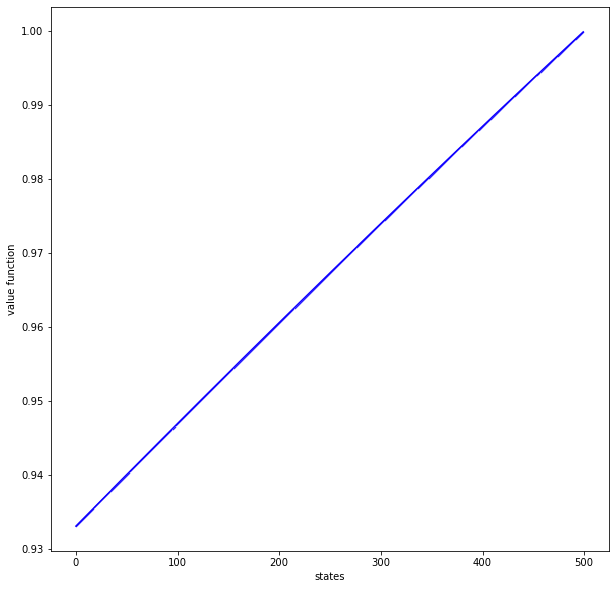

In [14]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(1, 1, 1)
ax.set_xlabel('states')
ax.set_ylabel('value function')
ax.plot(v.predict(S_test).flatten(), marker='.', color='#0F00FF', markersize=1, linestyle='-')

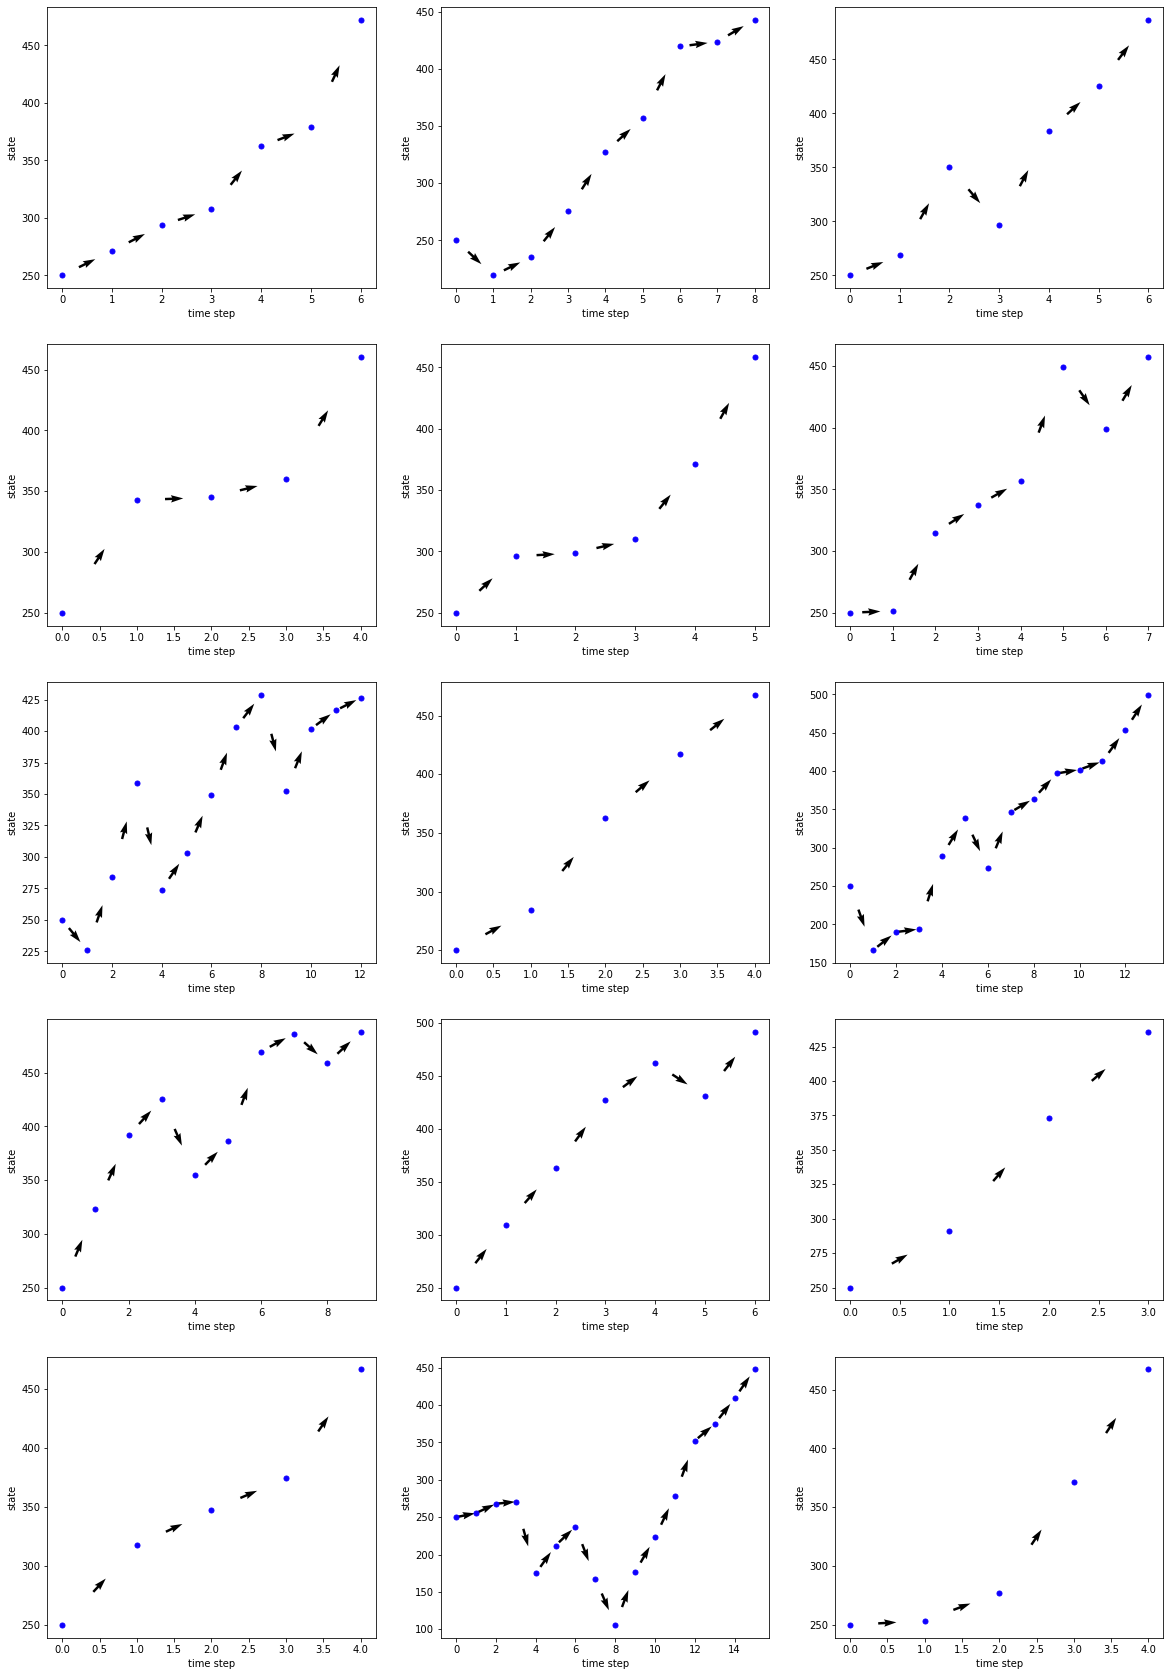

In [15]:
fig, axes = plt.subplots(figsize=(20,30),nrows=5, ncols=3)

for i in range(5):
    for j in range(3):
        x = np.array([i for i in range(len(policy_evaluation.agent.episodes[i*3+j]))])
        y = np.array(policy_evaluation.agent.episodes[i*3+j])

        u = np.diff(x)
        v = np.diff(y)
        pos_x = x[:-1] + u/2
        pos_y = y[:-1] + v/2
        norm = np.sqrt(u**2+v**2) 

        axes[i,j].set_xlabel('time step')
        axes[i,j].set_ylabel('state')
        axes[i,j].plot(x, y, marker='.', color='#0F00FF', markersize=10, linestyle='')
        axes[i,j].quiver(pos_x, pos_y, u/norm, v/norm, angles="xy", zorder=1, pivot="mid")